# TODO

1. Use generic utils to support configuration and both datasets
2. ~replicate Matan's scenario noise addition + plots ~
3. ~report baseline scores, comparison at the end~
4. ~add retraining lines to plots~
5. ~show drifts on second wave as well~
6. ~add the baseline RMSE drift to plot~
7. ask Yaniv about drift .fit() after retrain , history is deleted

# Installs and Download Demo data

In [66]:
# !pip install -q gdown

## Download Data Drift Module and Demo Data

In [67]:
import gdown

# Data Drift Module FROZEN version 28/12/2022 - can also be taken from:
# !git clone https://github.com/mryanivtal/mlops.git
!gdown --id 1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
!unzip -n mlops-main.zip
# !cp -n /content/drive/MyDrive/2023/S1/3690_MLOPs/mlops_project/POCs/mlops-main.zip . && 

# Sample dataset CSV file for the Demo
!gdown --id 1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
!gdown --id 1VfGsdyLDy2hEJKKIPWP6OTkvj5B5cbel
!gdown --id 1jSmwH1ysTdhWEe1KyB7f2xxegpGXda5P


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ta-5tC2LBW5CsrlxpomXHtC0obc29oEt
To: /content/mlops-main.zip
100% 103k/103k [00:00<00:00, 69.5MB/s]
Archive:  mlops-main.zip
a49255d5631c11a9dc153f03150c18205741b274
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1UFBAZTQJuNcrQptKWZ8jXFG7kxBBdOLg
To: /content/boston_housing.csv
100% 305k/305k [00:00<00:00, 84.1MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file 

# Imports

In [68]:
# generic 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split

import os
import sys 
sys.path.append('mlops-main/data_drift/')
sys.path.append('mlops-main/data_drift/drift_detection/')
sys.path.append('mlops-main/data_drift/helpers/')

# data drift specific
from boston_ds import BostonDS
import helpers.pipeline_utils as PLUtils
from helpers.utils import calc_perf_kpis
from helpers.model_helper import XgbModel
from helpers.data_helper import sample_from_data
from drift_detection.drift_detector import DriftDetector
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester


# Load configuration

In [69]:
selected_dataset = 'BOSTON'
# selected_dataset = 'CLAIMS'
if(selected_dataset=='BOSTON'):
  config_file = 'mlops-main/data_drift/boston_config.json'
  columns_to_modify = ['RM','LSTAT']
elif(selected_dataset=='CLAIMS'):
  config_file = 'mlops-main/data_drift/french_motor_claims_config.json'
  columns_to_modify = ['VehPower','Exposure']
else:
  print('Please set a configuration file to load in \'config_file\'')
  assert(False)

In [70]:
config_dict = PLUtils.load_configuration(config_file=config_file,verbose=True)

Loading configuration from: mlops-main/data_drift/boston_config.json
**********************************************************************
	Key=dataset_name,Value=Boston Housing
	Key=dataset_csv_path,Value=boston_housing.csv
	Key=cat_features,Value=[]
	Key=int_features,Value=['CHAS', 'RAD', 'TAX']
	Key=cont_features,Value=['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']
	Key=target_label,Value=PRICE
**********************************************************************


# Load dataset and Train Test Split

In [71]:
df_full=pd.read_csv(config_dict['dataset_csv_path'])
df_full.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.070457,18.0,2.31,0,0.538650,6.575,64.759142,4.093071,1,296,15.3,396.90,4.98,24.0
1,0.058989,0.0,7.07,0,0.469597,6.421,79.430377,4.963156,2,242,17.8,396.90,9.14,21.6
2,-0.091092,0.0,7.07,0,0.468406,7.185,61.133471,4.985532,2,242,17.8,392.83,4.03,34.7
3,-0.082456,0.0,2.18,0,0.458138,6.998,45.571149,6.060382,3,222,18.7,394.63,2.94,33.4
4,0.037007,0.0,2.18,0,0.458367,7.147,54.259141,6.073643,3,222,18.7,396.90,5.33,36.2


In [72]:
# ============================================================= Initial data setup
x_cat_features  = config_dict['cat_features']
x_int_features  = config_dict['int_features']
x_cont_features = config_dict['cont_features']
y_label         = config_dict['target_label']

X = df_full.drop(y_label,axis=1).copy()
y = df_full[y_label]
print(X.shape,y.shape)
# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 550 #1200 takes 1:26 min / With 2000 #each test 2 min / with 500 45 seconds
X_sample, y_sample = sample_from_data(X, y, TRAIN_TEST_SIZE)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.4, random_state=10)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(2530, 13) (2530,)


((330, 13), (330,), (220, 13), (220,))

In [73]:
display(X_train.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
456,4.718811,0.0,18.10,0,0.713722,5.976,88.152605,2.592035,24,666,20.2,10.48,19.01
251,0.357020,22.0,5.86,0,0.430065,6.438,8.693024,7.396260,7,330,19.1,377.07,3.59
1532,0.701071,0.0,8.14,0,0.537226,6.096,84.705303,4.496167,4,307,21.0,380.02,10.26
295,0.130440,0.0,13.92,0,0.436781,6.678,31.201013,5.960716,4,289,16.0,396.90,6.27
369,5.758898,0.0,18.10,1,0.631170,6.683,96.809768,1.353402,24,666,20.2,375.33,3.73


# Train and Evaluate a baseline model

### Baseline Model training and evaluation

In [74]:

# ============================================================= Train step
# Build model on train data
# Baseline model
def train_fresh_models(selected_dataset,X_train,y_train):
  '''
  Fresh start for baseline and production models
  (Returns two copies of the baseline model)
  '''
  baseline_model = XGBRegressor(objective='reg:squarederror')
  baseline_model.fit(X_train, y_train)

  saved_model_filename = selected_dataset + "_baseline_model.json"
  baseline_model.save_model(saved_model_filename)

  # Production model (a copy of the baseline initially)
  production_model = XGBRegressor(objective='reg:squarederror')
  production_model.load_model(saved_model_filename)

  return baseline_model,production_model

### Drift detector configuration and train

Create a drift detector and auto-select and fit drift testers based on feature types:
* Numeric features - Kolmogorov–Smirnov tester
* Categorical tests - Chi^2 tester
* All together - KL Divergence (Multivariable) tester

All testers default with pval=0.005, with three conseq. failures.

In Advanced mode - user can select other testers, p-vals, conseq failures.\n
Available testers:
* Kolmogorov–Smirnov
* Chi^2
* Multivariate KL Divergence with autofit
* Multivariate MMD (Max Mean Divergence) with autofit
* Multivatiate KS over PCA


In [75]:
# Create Feature drift detector with all default testers
drift_detector = DriftDetector()
drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
drift_detector.fit(X_train)

#One dummy drift detector for baseline model
base_drift_detector = DriftDetector()
base_drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
base_drift_detector.fit(X_train)

In [76]:
#TODO move to pipeline utils?
# Initial baseline predction / drift test plan
def get_model_kpi(model,drift_detector,X_test,y_test):
  '''
  Initial baseline predction / drift test plan
  '''
  y_pred = model.predict(X_test)
  kpi_sample = calc_perf_kpis(X_test, y_test, y_pred)
  return kpi_sample

# Common Utility Functions

In [77]:
def init_result_dfs(X_test,y_test,model):
  '''
  Calc and store initial model performance KPIs on test
  '''
  drift_test_results = drift_detector.test_drift(X_test)
  y_pred = model.predict(X_test)
  kpi = calc_perf_kpis(X_test, y_test, y_pred)

  kpi['drift_detected'] = drift_test_results['drift_detected']
  kpi['test_exceptions'] = drift_test_results['test_exceptions']
  kpi_keys = [k for k in kpi.keys()]
  kpi_columns = kpi_keys.append('retrain')
  kpi['retrain'] = False

  perf_kpis_prod = pd.DataFrame(columns=kpi_columns).append(kpi, ignore_index=True)
  perf_kpis_base = pd.DataFrame(columns=kpi_columns).append(kpi, ignore_index=True)

  return perf_kpis_base,perf_kpis_prod

In [78]:
# TODO move to a pipeline utils
def add_artificial_noise_to_data(X_sample,current_batch,columns_to_modify=[],start_drift_at_batch=100):
  '''
  Adds some noise to the data for simulating feature drift
  '''
  # modify data batch to create feature drift
  for c in columns_to_modify:
    X_sample[c] = X_sample[c] + X[c].std() * 0.01 * (current_batch - start_drift_at_batch)
  return X_sample.copy()

In [79]:
#TODO move to pipeline utils
MAX_RETRAIN_PATIENCE = 25# 45
# ============================================================= Runtime step
def run_drift_demo(X,y,number_of_batches = 300, start_drift_at_batch = 100,
                   sample_size = 50,columns_to_modify=[],
                   production_model=None,drift_detector=None,perf_kpis_prod=None,
                   baseline_model=None,baseline_drift_detector=None,perf_kpis_base=None,
                   retrain_on_drift=False):
  '''
  Runs inference in batches, while adding noise to the data to simulate drift
  Checks for data drift and evaluates the given models
  If a baseline model is given both models are being evaluated
  '''
  retrain_patience = 0
  X_copy = X.copy()
  y_copy = y.copy()
  # Runtime loop
  # Sample batch from data (No drift yet)
  for i in tqdm(range(number_of_batches)):
      X_sample, y_sample = sample_from_data(X_copy, y_copy, sample_size)

      # modify data batch to create feature drift
      if (i > start_drift_at_batch):
          X_sample = add_artificial_noise_to_data(X_sample,i,columns_to_modify,start_drift_at_batch)

      # predict
      y_pred = production_model.predict(X_sample)

      # calc RMSE (For demo only, cannot do in real runtime - no labels there
      kpi_sample = calc_perf_kpis(X_sample, y_sample, y_pred)

      # Execute drift test on batch (prod model)
      drift_test_results = drift_detector.test_drift(X_sample)
      kpi_sample['drift_detected'] = drift_test_results['drift_detected']
      kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
      kpi_sample['retrain'] = False

      #Check for drift 
      if((retrain_on_drift) and (drift_test_results['drift_detected'])):
        if(retrain_patience >= MAX_RETRAIN_PATIENCE):
          # print('retraining...due to drift')
          retrain_patience = 0
          production_model = XGBRegressor(objective='reg:squarederror')
          X_copy = X_copy.append(X_sample)
          y_copy = y_copy.append(y_sample)
          production_model.fit(X_copy, y_copy)
          # drift_detector.fit(X_copy)
          # production_model.fit(X_sample, y_sample)
          # drift_detector.fit(X_sample)
          
          kpi_sample['retrain'] = True
        else:
          # print('batch:{}, drift detected but skipping retraining...patience is:{}'.format(i,retrain_patience))
          retrain_patience+=1
      perf_kpis_prod = perf_kpis_prod.append(kpi_sample, ignore_index=True)

      # For comparison of two models predict on the same sample (!!!)
      y_pred_base = baseline_model.predict(X_sample)
      kpi_sample_base = calc_perf_kpis(X_sample, y_sample, y_pred_base)

      # Execute drift test on batch (baseline model)
      drift_test_results_base = baseline_drift_detector.test_drift(X_sample)
      kpi_sample_base['drift_detected'] = drift_test_results_base['drift_detected']
      kpi_sample_base['test_exceptions'] = drift_test_results_base['test_exceptions']
      perf_kpis_base = perf_kpis_base.append(kpi_sample_base, ignore_index=True)
    
  return drift_detector,perf_kpis_prod,baseline_drift_detector,perf_kpis_base


In [80]:
# ========================================================================== Plot
def display_run(perf_kpis,drift_detector,simulated_drift_started_at_batch=100,axs=None,title='',baseline_perf_kpis=None):

  # plot RMSE (Loss function) line
  axs.plot(perf_kpis['RMSE'])
  
  if baseline_perf_kpis is not None:
    axs.plot(baseline_perf_kpis['RMSE'])
    
    retrain_index = [r for r in perf_kpis_prod2[perf_kpis_prod2['retrain']==True].index]
    for r in retrain_index:
      # plot vertical line for each retraining
      # axs.axvline(x=r, label='retrain_'+str(r), color='purple', linestyle='dashed')
      axs.axvline(x=r, color='purple', linestyle='dashed')


  # plot vertical line for data drift start point
  axs.axvline(x=simulated_drift_started_at_batch, label='drift_start', color='r', linestyle='dashed')

  # Get drift detector x_history for plots
  x_history = drift_detector.history_df

  # plot vertical line for each tester that fired
  fail_detections = []
  cmap = get_cmap('hsv', 15)

  for i, test_name in enumerate(drift_detector.get_test_names()):
      if x_history[test_name].sum() > 0:
          detection_time = np.where(x_history[test_name] == True)[0].min()
          axs.axvline(x=detection_time, label=test_name, color=cmap(i))

  # Display plot
  axs.legend()
  axs.set_xlabel('batch number')
  axs.set_ylabel('RMSE')
  axs.set_title(title)

In [81]:
def show_drift_detection_step(perf_kpis_base,perf_kpis_prod,title=''):
  fig, axs = plt.subplots(2,1,figsize=(30, 5))
  base_y = perf_kpis_base['drift_detected']
  base_x = range(len(base_y))
  axs[0].step(base_x, base_y, '-r*', where='post',label='baseline')
  
  prod_y = perf_kpis_prod['drift_detected']
  prod_x = range(len(prod_y))
  axs[1].step(prod_x, prod_y, '-r*', where='post',label='production',color='navy')
  
  plt.xlabel('Batch number')
  plt.ylabel('Drift Status')
  axs[0].set_yticks([0,1])
  axs[1].set_yticks([0,1])
  axs[0].set_title('Baseline')
  axs[1].set_title('Production')
  plt.suptitle(title)
  plt.show()

In [82]:
def report_summary_kpi(perf_kpis_base,perf_kpis_prod,last_k_batches=100):
  '''
  Reports the summary KPI 
  '''
  mean_base = perf_kpis_base.iloc[-last_k_batches]['RMSE'].mean()
  mean_prod = perf_kpis_prod.iloc[-last_k_batches]['RMSE'].mean()
  diff_base_prod = mean_base-mean_prod
  print('Average RMSE on last 100 batches: Baseline:{:.4f} vs. Production:{:.4f}'.format(mean_base,mean_prod))
  if(selected_dataset=='BOSTON'):
    print('Production model is better by {:.4f} , a potential saving of {:.2f}$ for the house predictions company'.format(diff_base_prod,diff_base_prod*1000))
  else:
    print('Production model is better by {:.4f} , a potential saving of {:.2f} claims per customer'.format(diff_base_prod,diff_base_prod))


In [83]:
def init_test(X_train,y_train,X_test,y_test,
               x_cont_features,x_int_features,x_cat_features,
               selected_dataset):
  '''
  Init all required instances for a fresh test:
  Returns:
  1. 2 Models: baseline and production
  2. 2 drift detectors baseline and production
  3. 2 dataframes to collect the results
  '''

  baseline_model,production_model = train_fresh_models(selected_dataset,X_train,y_train)

  # Create Feature drift detector with all default testers
  drift_detector = DriftDetector()
  drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
  drift_detector.fit(X_train)

  #One dummy drift detector for baseline model
  base_drift_detector = DriftDetector()
  base_drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
  base_drift_detector.fit(X_train)

  perf_kpis_prod,perf_kpis_base = init_result_dfs(X_test,y_test,production_model)
    
  return drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,baseline_model,production_model

# Runtime 1 - Inference Drift Detection (no retraining)

In [84]:
%%time

# Init fresh start
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base,baseline_model,production_model = \
            init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector,perf_kpis_prod,base_drift_detector,perf_kpis_base = \
      run_drift_demo(X,y,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model,drift_detector=drift_detector,perf_kpis_prod=perf_kpis_prod,
                   baseline_model=baseline_model,baseline_drift_detector=base_drift_detector,perf_kpis_base=perf_kpis_base)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 47.6 s, sys: 1.41 s, total: 49 s
Wall time: 48.4 s


## Plot RMSE for Baseline vs. Production

Here they are identical
Drift detected but not handled

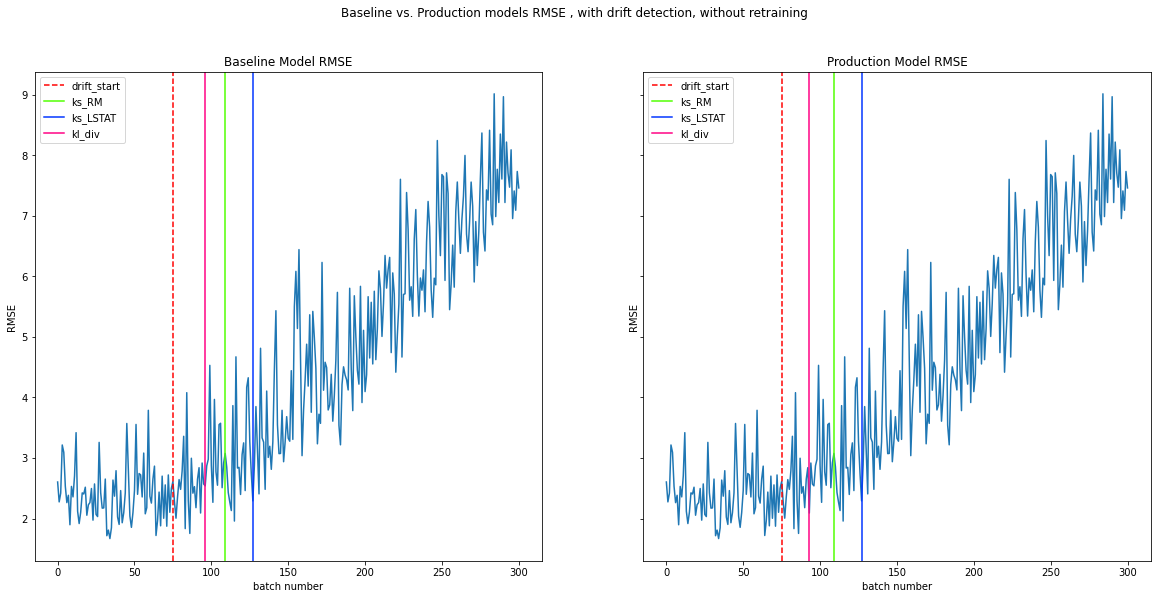

In [85]:
fig, axs = plt.subplots(1,2,figsize=(20, 9),sharey=True)
display_run(perf_kpis_base,base_drift_detector,start_drift_at_batch,axs[0],title='Baseline Model RMSE')
display_run(perf_kpis_prod,drift_detector,start_drift_at_batch,axs[1],title='Production Model RMSE')
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

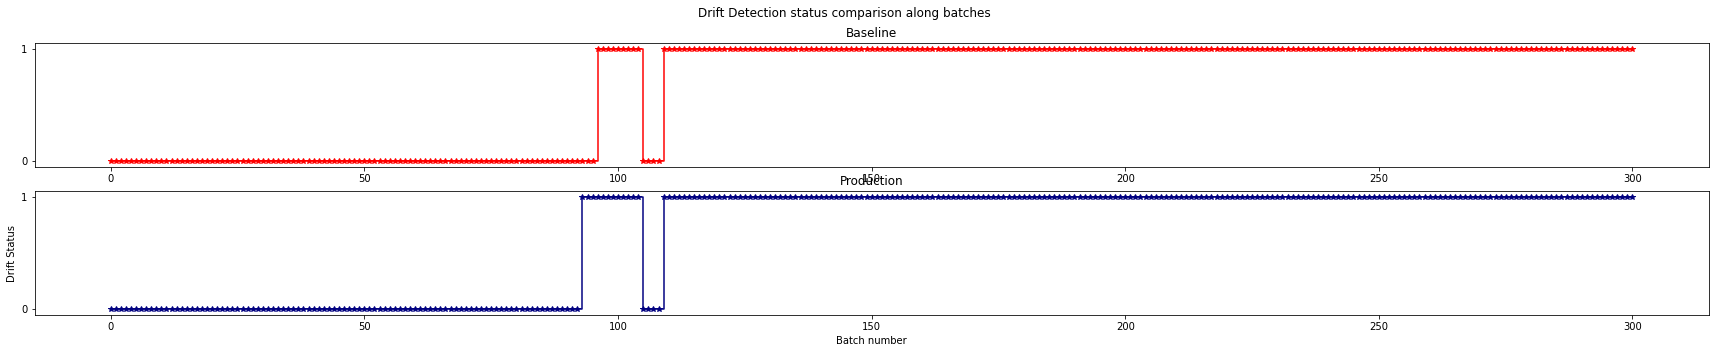

In [86]:
show_drift_detection_step(perf_kpis_base,perf_kpis_prod,title='Drift Detection status comparison along batches')

In [87]:
print('BASELINE')
perf_kpis_base

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.913701,0.908254,1.797106,1.797106,2.603852,0.0,[],0.0
1,0.928356,0.902484,1.645666,1.645666,2.275320,0.0,[],NaN
2,0.940280,0.918715,1.623466,1.623466,2.421022,0.0,[],NaN
3,0.877171,0.832816,2.005130,2.005130,3.215320,0.0,[],NaN
4,0.891660,0.852537,1.702113,1.702113,3.094255,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,-0.030405,-0.402496,6.143863,6.143863,6.954726,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
297,0.460849,0.266156,6.284742,6.284742,7.410776,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
298,0.247142,-0.024723,6.280617,6.280617,7.091707,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
299,0.366390,0.137587,6.102887,6.102887,7.732532,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN


In [88]:
print('PRODUCTION')
perf_kpis_prod

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.913701,0.908254,1.797106,1.797106,2.603852,0.0,[],0.0
1,0.928356,0.902484,1.645666,1.645666,2.275320,False,[],False
2,0.940280,0.918715,1.623466,1.623466,2.421022,False,[],False
3,0.877171,0.832816,2.005130,2.005130,3.215320,False,[],False
4,0.891660,0.852537,1.702113,1.702113,3.094255,False,[],False
...,...,...,...,...,...,...,...,...
296,-0.030405,-0.402496,6.143863,6.143863,6.954726,True,"[ks_RM, ks_LSTAT, kl_div]",False
297,0.460849,0.266156,6.284742,6.284742,7.410776,True,"[ks_RM, ks_LSTAT, kl_div]",False
298,0.247142,-0.024723,6.280617,6.280617,7.091707,True,"[ks_RM, ks_LSTAT, kl_div]",False
299,0.366390,0.137587,6.102887,6.102887,7.732532,True,"[ks_RM, ks_LSTAT, kl_div]",False


## Summary Results

Should be the same for both

In [89]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base.iloc[-1]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod.iloc[-1]['RMSE']))


Initial Baseline RMSE on test set: 2.6039
Initial Production RMSE on test set: 2.6039
**************************************************
Final Baseline RMSE on test set: 7.4608
Final Production RMSE on test set: 7.4608


# Runtime 2 - Inference Drift Detection (with retraining)

In [90]:
%%time

# Init fresh start
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2,baseline_model2,production_model2 = \
            init_test(X_train,y_train,X_test,y_test,
                      x_cont_features,x_int_features,x_cat_features,selected_dataset)

start_drift_at_batch = 75
#Baseline and Production comparison
drift_detector2,perf_kpis_prod2,base_drift_detector2,perf_kpis_base2 = \
      run_drift_demo(X,y,columns_to_modify=columns_to_modify,start_drift_at_batch=start_drift_at_batch,
                   production_model=production_model2,drift_detector=drift_detector2,perf_kpis_prod=perf_kpis_prod2,
                   baseline_model=baseline_model2,baseline_drift_detector=base_drift_detector2,
                   perf_kpis_base=perf_kpis_base2,retrain_on_drift=True,sample_size=100)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 51 s, sys: 1.27 s, total: 52.2 s
Wall time: 51.8 s


## Plot RMSE for Baseline vs. Production

Drift Detected and automatically handled by retraining

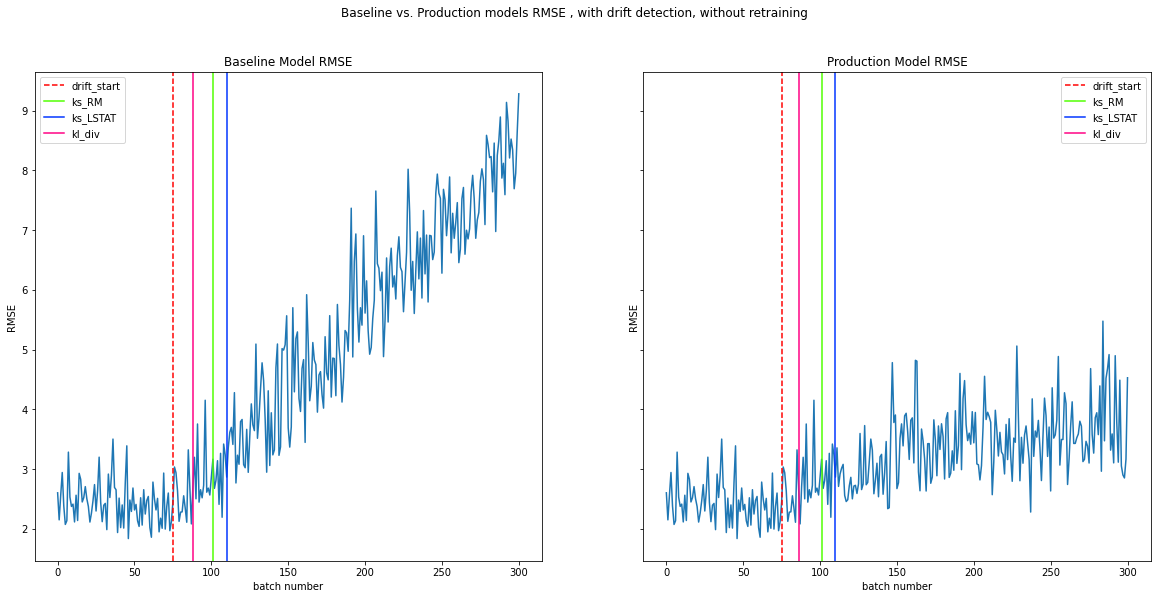

In [91]:
fig, axs = plt.subplots(1,2,figsize=(20, 9),sharey=True)
display_run(perf_kpis_base2,base_drift_detector2,start_drift_at_batch,axs[0],title='Baseline Model RMSE')
display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs[1],title='Production Model RMSE')
plt.suptitle('Baseline vs. Production models RMSE , with drift detection, without retraining')
plt.show()

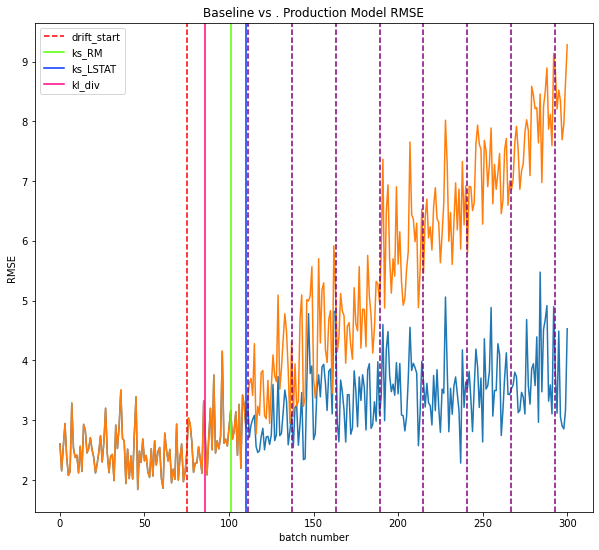

In [92]:
fig, axs = plt.subplots(1,1,figsize=(10, 9))
display_run(perf_kpis_prod2,drift_detector2,start_drift_at_batch,axs,title='Baseline vs . Production Model RMSE',baseline_perf_kpis=perf_kpis_base2)
plt.show()

In [93]:
print('BASELINE'),display(perf_kpis_base2)

BASELINE


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.913701,0.908254,1.797106,1.797106,2.603852,0.0,[],0.0
1,0.936422,0.926811,1.596899,1.596899,2.151226,0.0,[],NaN
2,0.916285,0.903631,1.809383,1.809383,2.562382,0.0,[],NaN
3,0.910319,0.896762,1.866591,1.866591,2.943602,0.0,[],NaN
4,0.940157,0.931111,1.486851,1.486851,2.383833,0.0,[],NaN
...,...,...,...,...,...,...,...,...
296,0.217574,0.099300,7.105176,7.105176,8.341584,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
297,0.230803,0.114529,6.542797,6.542797,7.691188,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
298,0.112482,-0.021678,6.813415,6.813415,7.952371,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN
299,-0.065224,-0.226246,7.150653,7.150653,8.653073,1.0,"[ks_RM, ks_LSTAT, kl_div]",NaN


(None, None)

In [94]:
print('PRODUCTION'),display(perf_kpis_prod2)

PRODUCTION


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions,retrain
0,0.913701,0.908254,1.797106,1.797106,2.603852,0.0,[],0.0
1,0.936422,0.926811,1.596899,1.596899,2.151226,False,[],False
2,0.916285,0.903631,1.809383,1.809383,2.562382,False,[],False
3,0.910319,0.896762,1.866591,1.866591,2.943602,False,[],False
4,0.940157,0.931111,1.486851,1.486851,2.383833,False,[],False
...,...,...,...,...,...,...,...,...
296,0.895113,0.879258,2.216223,2.216223,3.054135,True,"[ks_RM, ks_LSTAT, kl_div]",False
297,0.890438,0.873876,2.191522,2.191522,2.902722,True,"[ks_RM, ks_LSTAT, kl_div]",False
298,0.885814,0.868553,2.124531,2.124531,2.852431,True,"[ks_RM, ks_LSTAT, kl_div]",False
299,0.857265,0.835689,2.398744,2.398744,3.167487,True,"[ks_RM, ks_LSTAT, kl_div]",False


(None, None)

## Summary Results

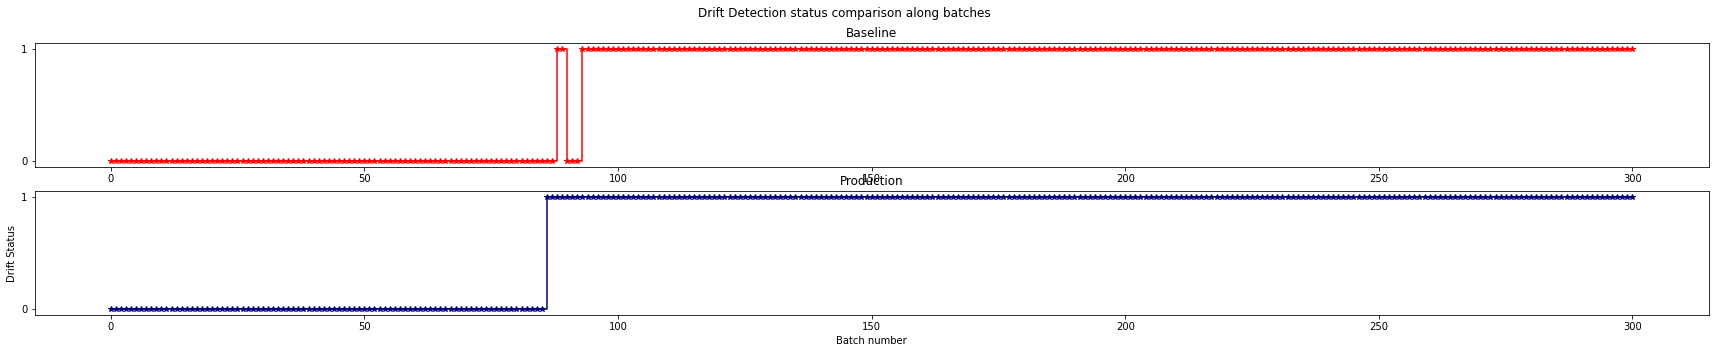

In [95]:
show_drift_detection_step(perf_kpis_base2,perf_kpis_prod2,title='Drift Detection status comparison along batches')

In [96]:
print('Initial Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[0]['RMSE']))
print('Initial Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[0]['RMSE']))
print('*'*50)
print('Final Baseline RMSE on test set: {:.4f}'.format(perf_kpis_base2.iloc[-100]['RMSE']))
print('Final Production RMSE on test set: {:.4f}'.format(perf_kpis_prod2.iloc[-100]['RMSE']))

Initial Baseline RMSE on test set: 2.6039
Initial Production RMSE on test set: 2.6039
**************************************************
Final Baseline RMSE on test set: 6.1504
Final Production RMSE on test set: 3.9481


In [97]:
report_summary_kpi(perf_kpis_base2,perf_kpis_prod2)

Average RMSE on last 100 batches: Baseline:6.1504 vs. Production:3.9481
Production model is better by 2.2023 , a potential saving of 2202.30$ for the house predictions company
